<a href="https://colab.research.google.com/github/google/evojax/blob/main/examples/notebooks/EncirclingAgents.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# @title Package installation
# @markdown Install EvoJAX (one time installation)

from IPython.display import clear_output

try:
    import evojax
except ModuleNotFoundError:
    !pip install flax==0.6.1  # Only needed in colab.
    !pip install evojax
    clear_output()
    import evojax

In [3]:
# @title Imports

import os
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'

from evojax.util import create_logger
from evojax.util import get_params_format_fn
from evojax.task.base import TaskState
from evojax.task.base import VectorizedTask
from evojax.policy.base import PolicyState
from evojax.policy.base import PolicyNetwork
from flax.struct import dataclass
from flax import linen as nn

import jax
import jax.numpy as jnp

import numpy as np
import matplotlib.pyplot as plt
from functools import partial
from PIL import Image
from IPython.display import Image as display_image
import logging

jax.local_devices()

[StreamExecutorGpuDevice(id=0, process_index=0, slice_index=0)]

# Task Definition

We are going to implement a task wherein 2 teams (blue and red) of agents play a hunting game with the following rules:
1. Agents on each team are randomly positioned on the left (blue team) and right (red team) side of the field.
2. An agent gets strengths from its neighbor grids to the North, East, South and West (max value: 4).
3. An agent gets no strength from a neighbor grid if it is occupied by an opponent agent or wall.
4. An agent dies if its total strength is less than 2.
5. At each step, an agent can stay still or move to one of the neighbor grids to the North, East, South and West.
6. An agent cannot move to a grid occupied by another agent or a wall.
7. The goal of each team is to hunt as many opponents as possible.
8. All agents get global observation of the entire field.

In [4]:
# State Definitions

@dataclass
class State(TaskState):
    field: jnp.ndarray
    obs: jnp.ndarray
    step: jnp.int32
    key: jnp.ndarray

In [5]:
# Task Definition

class EncirclingTask(VectorizedTask):
    """We assume we optimize the blue team and the red team acts randomly."""

    def __init__(self, max_steps, team_size, field_size, img_size, test=False):
        self.max_steps = max_steps
        self.test = test
        self.img_size = img_size
        self.field_size = field_size
        self.obs_shape = tuple([team_size * 2, 5])
        self.act_shape = tuple([team_size * 2,])
        actions = jnp.array([[0, 0], [-1, 0], [0, 1], [0, -1], [1, 0]],
                            dtype=jnp.int32)
        self.act_size = actions.shape[0]

        # === Helper functions ===

        get_fields = jax.vmap(
            lambda team_id, is_alive, pos: jnp.zeros(
                [field_size, field_size],
                dtype=jnp.int32).at[pos[0], pos[1]].set(team_id * is_alive))
        
        def create_field(team_ids, is_alive, team_positions):
            return jnp.max(
                get_fields(team_ids, is_alive, team_positions), axis=0)

        def apply_agent_actions(team_id, is_alive, pos, act, field):
            def scan_func(carry, x):
                t, l, p, a = x
                current_field = carry
                next_p = jnp.minimum(jnp.maximum(p + a, 0), field_size - 1)
                is_valid = jnp.bitwise_and(
                    l, current_field[next_p[0], next_p[1]] == 0)
                new_p = jnp.where(is_valid, next_p, p)
                current_field = jnp.where(
                    is_valid,
                    current_field.at[p[0], p[1]].set(0).at[
                        new_p[0], new_p[1]].set(t * l),
                    current_field)
                return current_field, new_p
            return jax.lax.scan(
                scan_func, field, (team_id, is_alive, pos, act))

        @partial(jax.vmap, in_axes=(0, 0, 0, None))
        def get_strength_at(team_id, is_alive, pos, field):
            strength_1 = jnp.where(  # No strength if this position is a wall.
                jnp.bitwise_or(
                    jnp.bitwise_or(pos[0] < 0, pos[0] >= field_size),
                    jnp.bitwise_or(pos[1] < 0, pos[1] >= field_size)), 0, 1) 
            strength_2 = jnp.where(  # No strenght if this position is enermy.
                jnp.bitwise_or(
                    field[pos[0], pos[1]] == 0,
                    field[pos[0], pos[1]] == team_id), 1, 0)
            return strength_1 * strength_2 * is_alive

        def get_strengths(team_id, is_alive, pos, field):
            neighbors = jnp.array(
                [[0, 1], [0, -1], [1, 0], [-1, 0]], dtype=jnp.int32)
            p_size = pos.shape[0]
            n_size = neighbors.shape[0]
            expanded_team_id = jnp.repeat(team_id, n_size, axis=0)
            expanded_is_alive = jnp.repeat(is_alive, n_size, axis=0)
            expanded_pos = (jnp.repeat(pos, repeats=n_size, axis=0) +
                            jnp.tile(neighbors, reps=(p_size, 1)))
            strengths = get_strength_at(
                expanded_team_id, expanded_is_alive, expanded_pos, field
            ).reshape(p_size, n_size)
            return strengths.sum(axis=-1)

        # === VectorizedTask implementations ===
    
        def reset_fn(key):

            agent_is_alive = jnp.ones(shape=(team_size * 2,), dtype=jnp.int32)
            agent_team_id = jnp.ones(
                shape=(team_size * 2,), dtype=jnp.int32).at[team_size:].set(2)

            next_key, key = jax.random.split(key)            
            blue_key, red_key = jax.random.split(key)
            ix = jax.random.choice(
                key=blue_key, a=field_size * (field_size // 2),
                shape=(team_size, 1), replace=False)
            col = ix % (field_size // 2)
            row = ix // (field_size // 2)
            blue_team_pos = jnp.hstack([row, col])            
            ix = jax.random.choice(
                key=red_key, a=field_size * (field_size // 2),
                shape=(team_size, 1), replace=False)
            col = ix % (field_size // 2) + (field_size // 2)
            row = ix // (field_size // 2)
            red_team_pos = jnp.hstack([row, col])
            agent_team_pos = jnp.vstack([blue_team_pos, red_team_pos])

            field = create_field(agent_team_id, agent_is_alive, agent_team_pos)
            agent_strength = get_strengths(
                agent_team_id, agent_is_alive, agent_team_pos, field) 
            obs = jnp.hstack([agent_team_id[..., None],
                              agent_is_alive[..., None],
                              agent_team_pos,
                              agent_strength[..., None]])

            return State(obs=obs, step=0, key=next_key, field=field)
        
        def step_fn(state, action):
            next_key, key = jax.random.split(state.key)

            # Agents on the blue team follow the given actions.
            action_ix = action[:team_size]
            blue_team_action = actions[action_ix]

            # Agents on the red team move randomly.
            action_ix = jax.random.choice(
                key, a=actions.shape[0], shape=(team_size,), replace=True)
            red_team_action = actions[action_ix]
            
            # Update obs and field.
            all_actions = jnp.vstack([blue_team_action, red_team_action])
            agent_team_id = state.obs[:, 0]
            current_is_alive = state.obs[:, 1]
            current_pos = state.obs[:, 2:4]
            new_field, new_pos = apply_agent_actions(
                agent_team_id, current_is_alive, current_pos,
                all_actions, state.field)
            strengths = get_strengths(
                agent_team_id, current_is_alive, new_pos, new_field)
            is_alive = jnp.bitwise_and(strengths >= 1, current_is_alive)
            strengths = strengths * is_alive
            obs = jnp.hstack([agent_team_id[..., None],
                              is_alive[..., None],
                              new_pos,
                              strengths[..., None]])
            field = create_field(agent_team_id, is_alive, new_pos)

            # Calculate reward (score) from the blue team's perspective.
            reward = (1. * is_alive[:team_size].sum()) / is_alive.sum()

            # Terminate if max_step is reached.
            done = jnp.where(state.step >= max_steps, 1, 0)

            return state.replace(obs=obs, field=field, step=state.step + 1,
                                 key=next_key), reward, done

        # === Wrap functions with jax.vmap and/or jax.jit ===

        self._reset_fn = jax.jit(jax.vmap(reset_fn))
        self._step_fn = jax.jit(jax.vmap(step_fn))

    def reset(self, key):  # Implement VectorizedTask.reset()
        return self._reset_fn(key)

    def step(self, state, action):  # Implement VectorizedTask.step()
        return self._step_fn(state, action)

    def render(self, state, task_id):
        obs = np.array(state.obs[task_id])
        field = np.array(state.field[task_id])
        img = np.ones([self.field_size, self.field_size, 3], dtype=np.uint8)
        ix = np.argwhere(field > 0)
        for row, col in ix:
            if field[row, col] == 1:
                img[row, col, :2] = 0
            else:
                img[row, col, 1:] = 0
        return Image.fromarray(img * 255).resize((self.img_size, self.img_size))

score=499.5821228027344


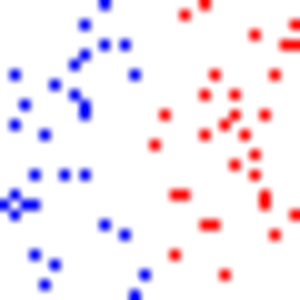

In [6]:
# Test the task with a policy that also moves randomly the agents.

IMAGE_SIZE = 300 # @param
FIELD_SIZE = 30  # @param
TEAM_SIZE = 30 # @param
MAX_STEPS = 1000  # @param
SEED = 0  # @param
NUM_TASKS = 16  # @param

imgs = []
num_blue_agents = []

task = EncirclingTask(
    max_steps=MAX_STEPS,
    team_size=TEAM_SIZE,
    field_size=FIELD_SIZE,
    img_size=IMAGE_SIZE,
    test=True,
)
key = jax.random.PRNGKey(seed=SEED)
reset_key, key = jax.random.split(key)
t_state = task.reset(jax.random.split(reset_key, num=NUM_TASKS))
imgs.append(task.render(t_state, 0))
num_blue_agents.append(t_state.obs[0, :TEAM_SIZE, 1].sum())

total_reward = 0.
for i in range(MAX_STEPS):
    act_key, key = jax.random.split(key)
    act = jax.random.choice(
        act_key, a=task.act_size,
        shape=(NUM_TASKS, TEAM_SIZE), replace=True)
    t_state, reward, done = task.step(t_state, act)
    num_blue_agents.append(t_state.obs[0, :TEAM_SIZE, 1].sum())
    total_reward += np.array(reward)
    if i % 5 == 0:
        imgs.append(task.render(t_state, 0))

print('score={}'.format(total_reward.mean()))
gif_file = 'task.gif'
imgs[0].save(gif_file, save_all=True, append_images=imgs[2::2], loop=0)
display_image(open(gif_file, 'rb').read())

# Policy Implementation

Since the task is working correctly, let's optimize a policy to control the blue team and see if any intelligent behaviors will emerge.  
The first step is to define our policy, and the points to consider are:
1. Each agent gets to see the entire field.
2. However, we don't want its policy to increase in size if we increase the number of agents on both teams.
3. Also, the order of the agents on the field should not matter.

We will therefore implement a multi-head attention (MHA) policy network for this task.

In [7]:
# Implement an MHA.

class AttentionPolicy(nn.Module):

    act_size: int
    num_heads: int
    embed_dim: int
    hidden_dim: int

    @nn.compact
    def __call__(self, obs):

        # Data preprocessing.
        obs = obs.astype(jnp.float32)            # shape=(team_size * 2, 3)
        obs = obs.at[:, 0].add(-1.5)             # team_id in {-0.5, 0.5}
        obs = obs.at[:, 2:4].divide(FIELD_SIZE)  # positions in [0, 1]
        obs = obs.at[:, -1].divide(4.)           # strengths in [0, 1]

        # Multi-head Self-attention.
        att_outputs = []
        for i in range(self.num_heads):
            q = nn.Dense(self.embed_dim, use_bias=False)(obs)
            k = nn.Dense(self.embed_dim, use_bias=False)(obs)
            v = nn.Dense(self.embed_dim, use_bias=False)(obs)
            att = nn.softmax(jnp.matmul(q, k.T), axis=-1)
            att_outputs.append(jnp.matmul(att, v))
        x = jnp.concatenate(att_outputs, axis=-1)

        # Pass through a feedford network.
        x = jnp.concatenate([obs, x], axis=-1)
        x = nn.tanh(nn.Dense(self.hidden_dim)(x))
        x = nn.tanh(nn.Dense(self.hidden_dim)(x))
        x = nn.Dense(self.act_size)(x)
        
        return jnp.argmax(x, axis=-1)


class EncirclingPolicy(PolicyNetwork):

    def __init__(self, act_size, num_heads, embed_dim, hidden_dim, logger=None):
        if logger is None:
            self._logger = create_logger(name='EncirclingPolicy')
        else:
            self._logger = logger

        model = AttentionPolicy(
            act_size=act_size, num_heads=num_heads,
            embed_dim=embed_dim, hidden_dim=hidden_dim)
        params = model.init(jax.random.PRNGKey(seed=0), obs=jnp.ones([10, 5]))
        self.num_params, format_params_fn = get_params_format_fn(params)
        self._logger.info(
            'EncirclingPolicy.num_params={}'.format(self.num_params))
        
        self._format_params_fn = jax.vmap(format_params_fn)
        self._forward_fn = jax.vmap(model.apply)

    def get_actions(self, t_states, params, p_states):
        params = self._format_params_fn(params)
        act = self._forward_fn(params, t_states.obs)
        return act, p_states

EncirclingPolicy: 2023-02-12 03:04:19,115 [INFO] EncirclingPolicy.num_params=4421


num_params=4421
score=503.05950927734375


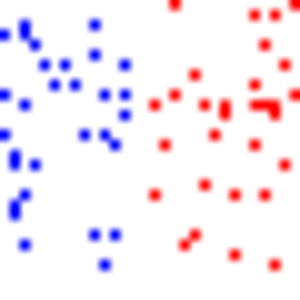

In [8]:
# Test the task with a randomly initialized policy.

NUM_HEADS = 4 # @param
EMBED_DIM = 16 # @param
HIDDEN_DIM = 32  # @param

imgs = []

key = jax.random.PRNGKey(seed=SEED)
next_key, key = jax.random.split(key)
t_state = task.reset(jax.random.split(key, num=NUM_TASKS))

# Initialize a policy.
policy = EncirclingPolicy(
    act_size=task.act_size,
    num_heads=NUM_HEADS,
    embed_dim=EMBED_DIM,
    hidden_dim=HIDDEN_DIM,
)
num_params = policy.num_params
print('num_params={}'.format(num_params))
params = jax.random.normal(key, shape=[NUM_TASKS, num_params])
p_state = policy.reset(t_state)
get_act_fn = jax.jit(policy.get_actions)

total_reward = 0.
for i in range(MAX_STEPS):
    act, p_state = get_act_fn(t_state, params, p_state)
    t_state, reward, done = task.step(t_state, act)
    total_reward += np.array(reward)
    if i % 5 == 0:
        imgs.append(task.render(t_state, 0))

print('score={}'.format(total_reward.mean()))
gif_file = 'rand_policy.gif'
imgs[0].save(gif_file, save_all=True, append_images=imgs[2::2], loop=0)
display_image(open(gif_file, 'rb').read())

# Train with EvoJAX

In [17]:
from evojax import Trainer
from evojax.algo import PGPE
import time


MAX_ITER = 1000  # @param
POP_SIZE = 64  # @param
TRAIN_SEED = 42  # @param

log_dir = './log'
logger = create_logger(name='Tutorial', log_dir=log_dir)
logger.setLevel(logging.INFO)
logger.info('Start training')
solver = PGPE(
    pop_size=POP_SIZE,
    param_size=policy.num_params,
    optimizer='adam',
    center_learning_rate=0.05,
    # init_stdev=0.07,
    stdev_learning_rate=0.05,
)
train_task = EncirclingTask(
    max_steps=MAX_STEPS,
    team_size=TEAM_SIZE,
    field_size=FIELD_SIZE,
    img_size=IMAGE_SIZE,
    test=False,
)
test_task = EncirclingTask(
    max_steps=MAX_STEPS,
    team_size=TEAM_SIZE,
    field_size=FIELD_SIZE,
    img_size=IMAGE_SIZE,
    test=True,
)
trainer = Trainer(
    policy=policy,
    solver=solver,
    train_task=test_task,
    test_task=test_task,
    max_iter=MAX_ITER,
    log_interval=10,
    test_interval=100,
    n_repeats=8,
    seed=TRAIN_SEED,
    log_dir=log_dir,
    logger=logger,
)

start_time = time.perf_counter()
trainer.run()
time_cost = time.perf_counter() - start_time
logger.info('time_cost={0:.2f}s'.format(time_cost))

Tutorial: 2023-02-12 09:35:10,285 [INFO] Start training
Tutorial: 2023-02-12 09:35:10,347 [INFO] use_for_loop=False
Tutorial: 2023-02-12 09:35:10,387 [INFO] Start to train for 1000 iterations.
Tutorial: 2023-02-12 09:36:02,182 [INFO] Iter=10, size=64, max=504.1255, avg=504.1255, min=504.1255, std=0.0000
Tutorial: 2023-02-12 09:36:47,155 [INFO] Iter=20, size=64, max=519.7056, avg=507.8850, min=496.7513, std=6.2863
Tutorial: 2023-02-12 09:37:32,122 [INFO] Iter=30, size=64, max=533.7719, avg=514.3684, min=503.2379, std=7.2892
Tutorial: 2023-02-12 09:38:17,096 [INFO] Iter=40, size=64, max=539.0549, avg=517.3066, min=499.9223, std=9.4750
Tutorial: 2023-02-12 09:39:02,061 [INFO] Iter=50, size=64, max=551.7631, avg=528.9699, min=511.5537, std=10.2776
Tutorial: 2023-02-12 09:39:47,025 [INFO] Iter=60, size=64, max=564.1031, avg=539.9364, min=505.8401, std=12.5306
Tutorial: 2023-02-12 09:40:31,998 [INFO] Iter=70, size=64, max=584.7162, avg=548.6700, min=513.7894, std=13.5555
Tutorial: 2023-02-12

score=686.712890625


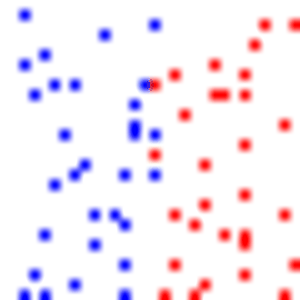

In [19]:
# Test the task with the trained policy.

imgs = []
eval_task = EncirclingTask(
    max_steps=MAX_STEPS,
    team_size=TEAM_SIZE,
    field_size=FIELD_SIZE,
    img_size=IMAGE_SIZE,
    test=True,
)

key = jax.random.PRNGKey(seed=SEED)
t_state = eval_task.reset(jax.random.split(key, num=NUM_TASKS))

params = jnp.repeat(solver.best_params[None, ...], repeats=NUM_TASKS, axis=0)
p_state = policy.reset(t_state)
get_act_fn = jax.jit(policy.get_actions)

total_reward = 0.
for i in range(MAX_STEPS):
    act, p_state = get_act_fn(t_state, params, p_state)
    t_state, reward, done = eval_task.step(t_state, act)
    total_reward += np.array(reward)
    if i % 5 == 0:
        imgs.append(eval_task.render(t_state, 0))

print('score={}'.format(total_reward.mean()))
gif_file = 'trained_policy.gif'
imgs[0].save(gif_file, save_all=True, append_images=imgs[1:], loop=0)
display_image(open(gif_file, 'rb').read())